In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from video import *
import numpy as np
import ultralytics
import cv2 as cv
from utils import *

In [3]:
if 'query' in globals():
    del query
if 'reference' in globals():
    del reference

query = load_video("train/task1/06_query.mp4")
reference = load_video("train/task1/06_reference.mp4")

In [4]:
query.do_tracking()
reference.do_tracking()

In [5]:
camera_query = query.get_camera()
camera_reference = reference.get_camera()

print("Query camera:", camera_query)
print("Reference camera:", camera_reference)

Query camera: A
Reference camera: B


In [7]:
F = np.load("homography_matrices/AB.npy")
print(F)
F_inv = np.load("homography_matrices/BA.npy")
print(F_inv)

[[    0.47378      1.5811       -2115]
 [    0.12711      -2.314       683.5]
 [ 0.00030332  -0.0033319           1]]
[[  -0.083615     -3.4141        2435]
 [   -0.11113     -0.8211      501.78]
 [-0.00027633  -0.0014603           1]]


In [8]:
# Find the frame with the most keypoints 

best_frame_index = 0
max_keypoints = 0

for i in range(query.num_frames()):
    frame = query.get_frame(i)
    keypoints = get_keypoints(frame, F)

    if len(keypoints) > max_keypoints:
        max_keypoints = len(keypoints)
        best_frame_index = i
print("Best frame index:", best_frame_index, max_keypoints)

Best frame index: 143 7


In [34]:
query_index = 0
reference_index = 465 

[{'position': (808, 995), 'class': 'car'}, {'position': (1534, 856), 'class': 'car'}, {'position': (429, 669), 'class': 'truck'}, {'position': (1222, 789), 'class': 'truck'}]
[{'position': (892, 946), 'class': 'car'}, {'position': (150, 789), 'class': 'car'}, {'position': (202, 738), 'class': 'car'}, {'position': (307, 824), 'class': 'truck'}, {'position': (956, 716), 'class': 'car'}]


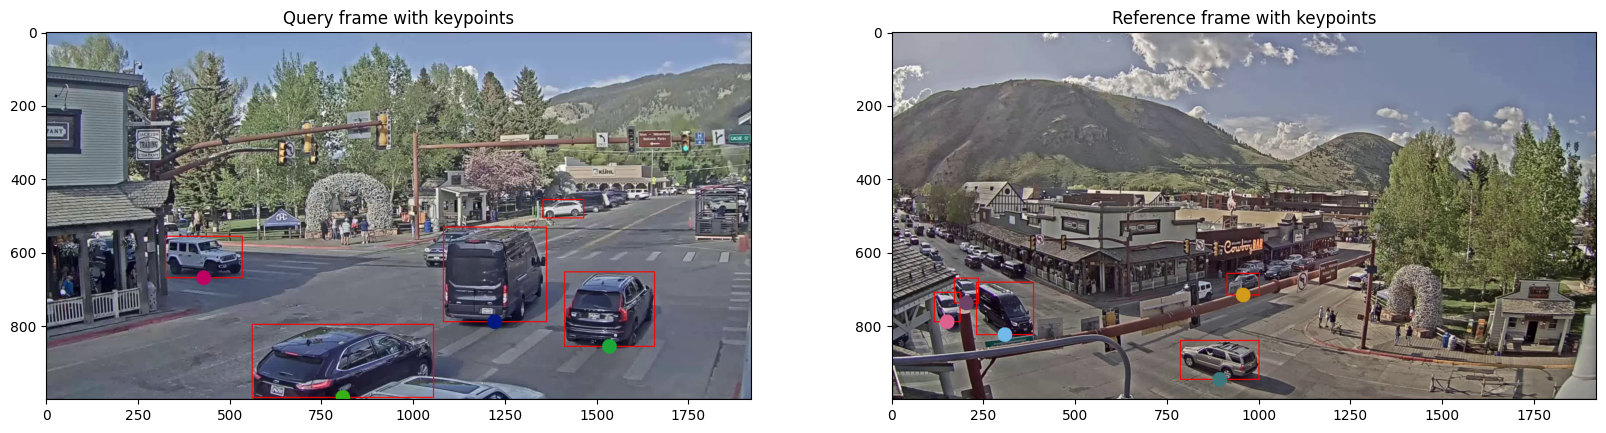

In [ ]:
query_frame = query.get_frame(query_index)
query_frame_plot = query_frame.raw().copy()
reference_frame = reference.get_frame(reference_index)
reference_frame_plot = reference_frame.raw().copy()
colors = []

for object in query_frame.get_objects():
    x1, y1, x2, y2 = object["bbox"]
    cv.rectangle(query_frame_plot, (x1, y1), (x2, y2), (255, 0, 0), 2)

keypoints1 = get_keypoints(query_frame, F)
print(keypoints1)
for keypoint in keypoints1:
    color = np.random.randint(0, 255, size=3).tolist()
    colors.append(color)
    cv.circle(query_frame_plot, keypoint["position"], 20, color, -1)

######################################################################
for object in reference_frame.get_objects():
    x1, y1, x2, y2 = object["bbox"]
    cv.rectangle(reference_frame_plot, (x1, y1), (x2, y2), (255, 0, 0), 2)

keypoints2 = get_keypoints(reference_frame, F_inv)
print(keypoints2)

for keypoint in keypoints2:
    color = np.random.randint(0, 255, size=3).tolist()
    cv.circle(reference_frame_plot, keypoint["position"], 20, color, -1)

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].set_title("Query frame with keypoints")
ax[0].imshow(query_frame_plot)
ax[1].set_title("Reference frame with keypoints")
ax[1].imshow(reference_frame_plot)
plt.show()

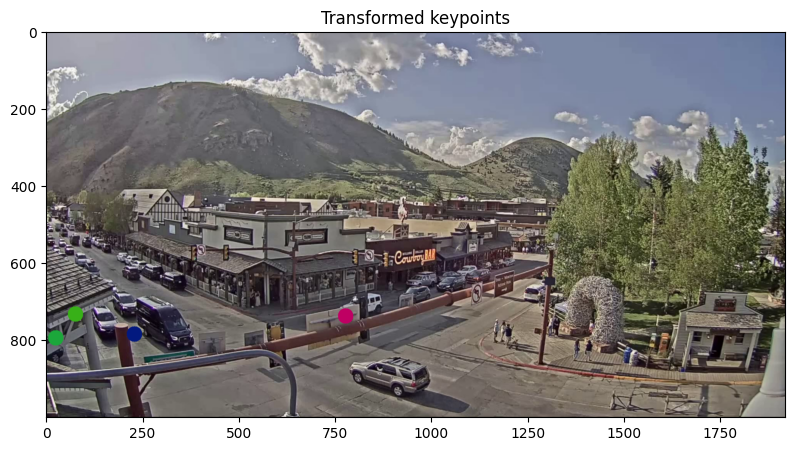

In [46]:
reference_frame = reference.get_frame(reference_index)
reference_frame_plot = reference_frame.raw().copy()

for i, keypoint in enumerate(keypoints1):
    pos1_tmp = np.array([[keypoint["position"]]]).astype(np.float32)
    transformed = cv.perspectiveTransform(pos1_tmp, F).squeeze().astype(np.int32)

    cv.circle(reference_frame_plot, transformed, 20, colors[i], -1)

plt.figure(figsize=(10, 5))
plt.title("Transformed keypoints")
plt.imshow(reference_frame_plot)
plt.show()

(808, 995) (202, 738)
(1534, 856) (150, 789)
(429, 669) (892, 946)
(1222, 789) (307, 824)


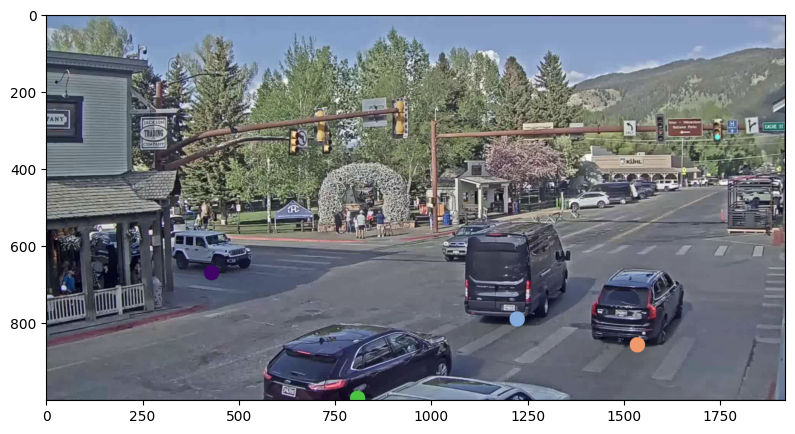

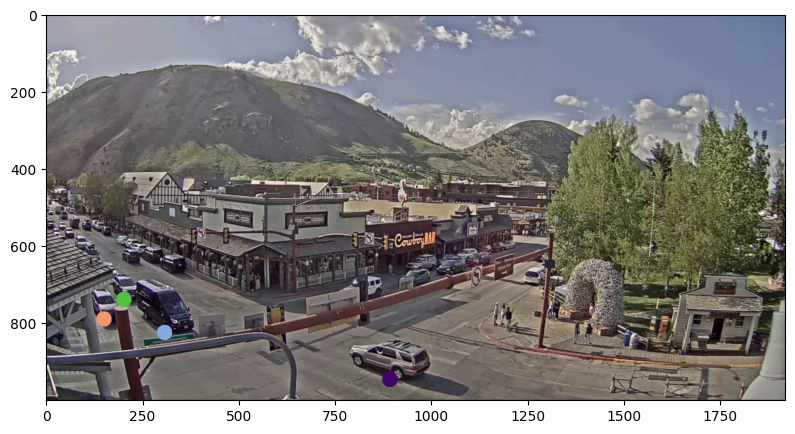

In [47]:
matching_query = query_frame.raw().copy()
matching_reference = reference_frame.raw().copy()

assignment, cost, _ = get_assignment(keypoints1, keypoints2, F)

for i in range(len(assignment[0])):
    a = assignment[0][i]
    b = assignment[1][i]

    keypoint_a = keypoints1[a]["position"]
    keypoint_b = keypoints2[b]["position"]
    print(keypoint_a, keypoint_b)

    color = np.random.randint(0, 255, size=3).tolist()

    cv.circle(matching_query, keypoint_a, 20, color, -1)
    cv.circle(matching_reference, keypoint_b, 20, color, -1)

plt.figure(figsize=(10, 5))
plt.imshow(matching_query)
plt.show()
plt.figure(figsize=(10, 5))
plt.imshow(matching_reference)
plt.show()

In [48]:
num_query_frames = query.num_frames()
num_reference_frames = reference.num_frames()
print(num_query_frames)
costs = []

for i in range(0, num_reference_frames-num_query_frames+1):
    total_cost = 0

    for t in range(num_query_frames):
        frame_a = query.get_frame(t)
        frame_b = reference.get_frame(i + t)

        keypoints1 =  get_keypoints(frame_a, F) 
        keypoints2 =  get_keypoints(frame_b, F_inv) 

        assingment, cost, _ = get_assignment(keypoints1, keypoints2, F) 
        total_cost += cost

    costs.append(total_cost)
    print(f"Frame {i}: cost = {total_cost:.2f}")

180
Frame 0: cost = 1020897.94
Frame 1: cost = 1016760.73
Frame 2: cost = 1014858.19
Frame 3: cost = 1011300.40
Frame 4: cost = 1005511.84
Frame 5: cost = 999710.26
Frame 6: cost = 993916.48
Frame 7: cost = 989795.89
Frame 8: cost = 987105.91
Frame 9: cost = 986635.22
Frame 10: cost = 986171.07
Frame 11: cost = 983506.49
Frame 12: cost = 981579.81
Frame 13: cost = 980871.33
Frame 14: cost = 980155.51
Frame 15: cost = 977209.75
Frame 16: cost = 974277.54
Frame 17: cost = 975771.56
Frame 18: cost = 977350.09
Frame 19: cost = 974465.37
Frame 20: cost = 972800.50
Frame 21: cost = 973638.76
Frame 22: cost = 972613.05
Frame 23: cost = 973418.09
Frame 24: cost = 972291.15
Frame 25: cost = 971108.46
Frame 26: cost = 972307.10
Frame 27: cost = 973315.90
Frame 28: cost = 978442.21
Frame 29: cost = 983571.69
Frame 30: cost = 988745.89
Frame 31: cost = 993943.07
Frame 32: cost = 996464.06
Frame 33: cost = 998791.76
Frame 34: cost = 1001120.33
Frame 35: cost = 1003435.92
Frame 36: cost = 1005753.50

465


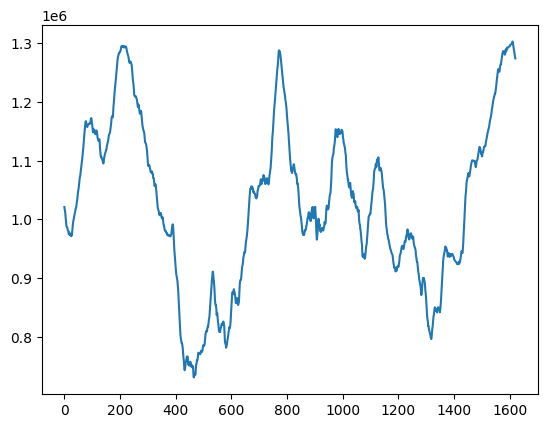

In [49]:
plt.plot(costs)
print(np.argmin(costs))